In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

import matplotlib

%matplotlib inline

plt.rcParams['font.family'] = 'Cambria'
plt.rcParams['mathtext.fontset'] = 'stix'

matplotlib.rcParams['text.usetex'] = True

from scipy.optimize import least_squares

In [24]:
freeSpdThreshold = 55 * 1.6 # unit: km/h

def freeState(x, den, vol):
    return x[0] * den - vol

#def congState(x, cap, den, criticalDen, vol):
#    return cap - x[0]*(den-criticalDen) - vol

def congState(x, den, criticalDen, vol):
    return x[1] - x[0]*(den-criticalDen) - vol

def partitionBins(den, vol, binsize=10):
    for i in range(len(vol)):
        vol[i] += np.random.rand() / 100
        
    if len(set(vol)) != len(vol):
        print('Warning in partitionBins().')
        
    vol = sorted(vol, key=lambda x: den[vol.index(x)])
    den = sorted(den)
    
    numBin = len(vol) // binsize
    
    binnedDen = [np.mean(den[(binsize*i):(binsize*(i+1))]) for i in range(numBin)]
    binnedVol = [np.array(vol[(binsize*i):(binsize*(i+1))]) for i in range(numBin)]
        
    for i in range(numBin):
        q1 = np.quantile(binnedVol[i], 0.25)
        q3 = np.quantile(binnedVol[i], 0.75) 
        binnedVol[i] = np.max(binnedVol[i][np.where(binnedVol[i]<(q3+0*(q3-q1)), True, False)])
        #binnedVol[i] = np.max(binnedVol[i])

    return binnedDen, binnedVol

In [25]:
totalVol = pd.read_csv('Preprocessed Data/totalVol(veh_h).csv', index_col=0)
mainSpd = pd.read_csv('Preprocessed Data/mainSpd(km_h).csv', index_col = 0)
mainDen = pd.read_csv('Preprocessed Data/mainDen(veh_km).csv', index_col = 0)

cells = pd.read_csv('Preprocessed Data/cells.csv', index_col=0)

In [26]:
estimatedFreeSpd = {}
estimatedCapacity = {}
estimatedCriticalDen = {}
estimatedJamDen = {}
estimatedCongSpd = {}
estimatedDrop = {}

for i in range(1, 21):
    cellName = cells.loc[i]['ID']
    # Use the data from Monday to Thursday for calibration
    den = np.array(mainDen.loc[cellName][288:(288*5)])
    vol = np.array(totalVol.loc[cellName][288:(288*5)])
    spd = np.array(mainSpd.loc[cellName][288:(288*5)])
    
    freeDen = den[spd>=freeSpdThreshold]
    freeVol = vol[spd>=freeSpdThreshold]
    
    estimatedFreeSpd[cellName] = least_squares(freeState, np.array([100]), args=(freeDen, freeVol)).x[0]
    estimatedCapacity[cellName] = np.max(vol)
    estimatedCriticalDen[cellName] = estimatedCapacity[cellName]/estimatedFreeSpd[cellName]
    
    congDen = den[den>estimatedCriticalDen[cellName]]
    congVol = vol[den>estimatedCriticalDen[cellName]]
    
    binnedDen, binnedVol = partitionBins(list(congDen), list(congVol))
    binnedDen = np.array(binnedDen)
    binnedVol = np.array(binnedVol)
    
    congestionFitting = least_squares(congState, np.array([100, 100]), 
                                      args=(binnedDen, 
                                            np.array([estimatedCriticalDen[cellName]]*len(binnedDen)),
                                            binnedVol))
    
    #congestionFitting = least_squares(congState, np.array([100, 100]), 
    #                                  args=(congDen, 
    #                                        np.array([estimatedCriticalDen[cellName]]*len(congDen)),
    #                                        congVol))
    
    estimatedCongSpd[cellName] =  congestionFitting.x[0]
    estimatedDrop[cellName] = congestionFitting.x[1]
    estimatedJamDen[cellName] = estimatedCriticalDen[cellName] + congestionFitting.x[1]/congestionFitting.x[0]




In [27]:
estimatedCongSpd[761177] = 25
estimatedDrop[761177] = estimatedCapacity[761177]
estimatedJamDen[761177] = estimatedDrop[761177] / estimatedCongSpd[761177] 

estimatedCongSpd[772872] = 25
estimatedDrop[772872] = estimatedCapacity[772872]
estimatedJamDen[772872] = estimatedDrop[772872] / estimatedCongSpd[772872] 


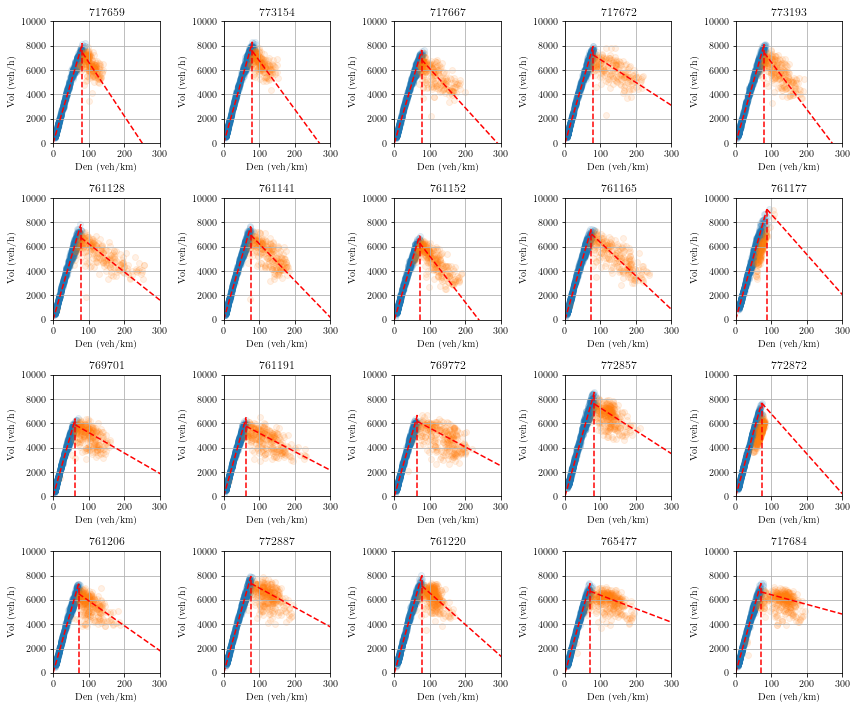

In [28]:
plt.figure(figsize=(12, 12))
for i in range(1, 21):
    cellName = cells.loc[i]['ID']
    plt.subplot(5, 5, i)
    
    den = np.array(mainDen.loc[cellName][288:(288*5)])
    vol = np.array(totalVol.loc[cellName][288:(288*5)])
    spd = np.array(mainSpd.loc[cellName][288:(288*5)])
    
    plt.scatter(den[spd>=freeSpdThreshold], vol[spd>=freeSpdThreshold], alpha=0.1)
    plt.scatter(den[spd<freeSpdThreshold], vol[spd<freeSpdThreshold], alpha=0.1)
    
    
    criticalDen = estimatedCriticalDen[cellName]
    jamDen = estimatedJamDen[cellName]
    
    cap = estimatedCapacity[cellName]
    congSpd = estimatedCongSpd[cellName]
    drop = estimatedDrop[cellName]
    
    plt.plot([criticalDen, criticalDen], [0, cap], 'r--')
    plt.plot([0, criticalDen], [0, cap], 'r--')
    plt.plot([criticalDen, jamDen], [drop, drop-jamDen*congSpd], 'r--')

    plt.title(cellName)
    plt.ylabel('Vol (veh/h)')
    plt.xlabel('Den (veh/km)')
    plt.ylim([0, 10000])
    plt.xlim([0, 300])
    plt.grid()

plt.tight_layout()
plt.show()

In [35]:
calibratedFD = {}
for i in estimatedCapacity.keys():
    calibratedFD[i] = {'cap(veh/h)': np.round(estimatedCapacity[i]),
                       'freeSpd(km/h)': np.round(estimatedFreeSpd[i]),
                       'criticalDen(veh/km)': np.round(estimatedCriticalDen[i]),
                       'congSpd(km/h)': np.round(estimatedCongSpd[i]),
                       'maxDen(veh/km)': np.round(estimatedJamDen[i]),
                       'dropCap(veh/h)': np.round(estimatedDrop[i])}

In [36]:
pd.DataFrame(calibratedFD).transpose().to_csv('Preprocessed Data/FDCalibration.csv')

In [37]:
pd.DataFrame(calibratedFD).transpose()

,cap(veh/h),congSpd(km/h),criticalDen(veh/km),dropCap(veh/h),freeSpd(km/h),maxDen(veh/km)
717659,8208.0,32.0,83.0,7431.0,99.0,312.0
773154,8340.0,30.0,81.0,7548.0,103.0,331.0
717667,7668.0,25.0,77.0,6858.0,100.0,350.0
717672,7968.0,16.0,79.0,7259.0,101.0,532.0
773193,8136.0,29.0,81.0,7420.0,101.0,333.0
761128,7836.0,19.0,78.0,6758.0,100.0,435.0
761141,7692.0,24.0,76.0,6967.0,101.0,367.0
761152,6924.0,29.0,71.0,6313.0,98.0,292.0
761165,7488.0,22.0,74.0,7064.0,101.0,391.0
761177,9084.0,25.0,88.0,9084.0,103.0,363.0
